# Analysis of connection probabilities in the MICrONS dataset

The MICrONS initiative provided a dense reconstruction of around a cubic milimeter of mouse brain tissue.

At OBI, we have converted that data into the SONATA format that is often used to represent biophysically-detailed computational models of neuronal circuitry. We believe that this is a useful resource for the community for the following reasons:
 1. It allows direct comparison of models to the data, as both are in the same format. In the future it may even be possible to simulate the MICrONS circuitry as one simulates the computational models.
 2. There are many useful code libraries for analyzing SONATA-formatted circuits.
 3. It is reduced representation of the data. While this discards a lot of information, what remains is still very useful for many purposes. And the reduced data can be more easily handled and analyzed faster.
 4. During the conversion to SONATA we added derived data. Specifically, high-quality morphology skeletons with extracted spines.


Here, we want to expand on point (3) above. We demonstrate an examplary use case, where we calculate connection probabilities and related quantities.

### Summary of the analysis

We calculate connection probabilities (within 100 um inter-soma distance), first for L5PCs, then for all pathways. For accuracy, we focus on neurons that have passed manual proofreading.

Next, we explore an alternative way of calculating connection probabilities: Instead of considering all pairs of neurons and filtering them to pairs within 100 um, we instead emulate a slicing and sampling procedure, such as is performed in the wetlab.

## Importing code libraries and loading the data

We import a number of standard packages, as well as _conntility_ . This package provides (as we will see) useful functionality for the analysis of this type of data.

In [ ]:
import conntility
import pandas
import numpy

from matplotlib import pyplot as plt

numpy.seterr(all="ignore")


fn = "../../../../shared_data/MICrONS_SONATA/microns_con_mat_multi.h5"

# We load the data that has been serialized into a single hdf5 file into an object.
M = conntility.ConnectivityMatrix.from_h5(fn)


### Side note: data representation

The data, that is, the neurons and their connections, are represented in the object M. 
The representation has a list of _vertices_, i.e. neurons, and _edges_, i.e. synaptic connections. 

We can list the vertices and their properties.
Important properties for this analysis are:
  - layer, a string indicating the cortical layer of each neuron
  - synapse_class, this is either "EXC" or "INH" indicating that a neuron is excitatory or inhibitory
  - x, y, z, the spatial locations of the neurons in um
  - status_axon, status_dendrite: this is "t" for neurons that have passed manual proofreading

In [ ]:
display(M.vertices)

## Limit to proofread neurons
For the first analysis, we filter the data such that only neurons with proofread axon and dendrites remain.

In [ ]:
M = M.index("status_dendrite").eq("t").index("status_axon").eq("t")
# Display number of neurons remaining
display(len(M))

A variety of different neuron types remain. We display their counts.

Note: The neuron classification is provided by MICrONS. Check the OBI portal page for more info.

In [ ]:
M.vertices["mtype"].value_counts()

### Focus on L5PCs

Next, we filter again, this time focusing on the four types of L5PC classes in the data.

In [ ]:
lst_mtypes_to_use = ["L5NP", "L5b", "L5a", "L5ET"]
M_fltr = M.index("mtype").isin(lst_mtypes_to_use)
display(len(M_fltr))

Simple overall connection probabilities can now be computed.

Note: .matrix provides the adjacency matrix of connectivity between the remaining 189 neurons. It is a sparse matrix, where nonzero entries have an integer value corresponding to the size of a synapse. Where multiple synapses exist between two neurons, this is the sum of sizes.

Here, we are only interested in the presence / absence of connections. So we convert the matrix to boolean values.

In [ ]:
# Number of connected pairs divided by number of potential pairs
display(M_fltr.matrix.astype(bool).sum() / (len(M_fltr) * (len(M_fltr) - 1)))

However, if we plot the locations of the neurons, we see a slight problem. 
The proofread L5PC population is scattered throughout the volume. Typically, only connection probabilities between nearby neurons are of interest.

Note: The "x" and "z" axes correspond roughly to the horizontal plane. "y" to a vertical, i.e., orthogonal to layer boundaries. 

In [ ]:
spat_axes = ["x", "z"]
plt.scatter(M_fltr.vertices[spat_axes[0]], M_fltr.vertices[spat_axes[1]])
plt.gca().set_xlabel("x (um)")
plt.gca().set_ylabel("y (um)")
plt.gca().set_title("Proofread L5PCs")

We see a roughly 100 by 100 um cluster of neurons and decide to focus on that.

In [ ]:
iv_x = [665, 770]
iv_z = [800, 910]

# Filter further based on location. "ge" = greater or equal. "le" = less or equal.
M_fltr = M_fltr.index("x").ge(iv_x[0]).index("x").le(iv_x[1])
M_fltr = M_fltr.index("z").ge(iv_z[0]).index("z").le(iv_z[1])

display(len(M_fltr)) # Number of neurons remaining
display(M_fltr.matrix.astype(bool).sum() / (len(M_fltr) * (len(M_fltr) - 1))) # Connection probability

We see that focusing on nearby neurons increases connection probability to ~6%.

We can use the "networkx" package to plot the network,

In [ ]:
import networkx

nx = M_fltr.to_networkx()

pos = dict([(k, [_node["x"], _node["z"]]) for k, _node in nx.nodes.items()])

networkx.draw(nx, pos=pos)
ax = plt.gca()
ylim = ax.get_ylim(); xlim = ax.get_xlim()
y_pos = 0.97 * ylim[0] + 0.03 * ylim[1]
x_pos = 0.1 * xlim[0] + 0.9 * xlim[1]
ax.plot(x_pos + numpy.array([-50.0, 0.0]),
        y_pos + numpy.zeros(2), lw=5, color="grey")
ax.text(x_pos - 25.0, y_pos - 5.0, "50 um",
        horizontalalignment="center")

## "Proper" connection probability

A more objective way of calculating connection probability works as follows: We consider all pairs, not only the ones inside the selected square. But then we filter the pairs down to pairs with a soma distance below 100 um.

In [ ]:
from scipy.spatial.distance import squareform, pdist, cdist

# Again, consider all proofread L5PCs, not just the square
M_fltr = M.index("mtype").isin(lst_mtypes_to_use)

# All pairwise distances
D = squareform(pdist(M_fltr.vertices[["x", "y", "z"]]))

in_interval = (D > 0) & (D <= 100.0)
n_pairs = in_interval.sum()
n_connected = M_fltr.array.astype(bool)[in_interval].sum()
con_prob = n_connected / n_pairs
print(f"{n_connected} out of {n_pairs} pairs are connected for a connection probability of {100*con_prob}%")

### Other reference for connection probability

In 2015, Jiang and colleagues performed an exhaustive sampling of connectivity between types of neurons in the same species and region.

Curiously, they found a 0% connection probability between L5PCs (0 out of 150 pairs connected).

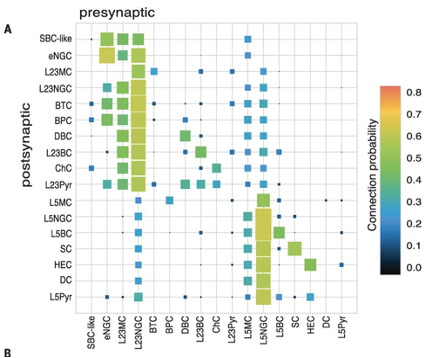

We now create a plot in the same style as the one of Jiang and colleagues plot above.

Note that we do not provide a completely comparative plot: The classification into neuron types Jiang et al. used is very different. Yet, an expert will be able to make some individual comparisons.

We encourage interested readers to make the plot more comparable: Either by mapping neuron classes to each other, or by re-classifying neurons in the MICrONS data according to Jiang et al. For most proofread MICrONS neurons, we provide their morphologies and they can be used for that purpose.



In [ ]:
M = conntility.ConnectivityMatrix.from_h5(fn)
M = M.index("status_dendrite").eq("t").index("status_axon").eq("t")

def conn_prob_within_100um(mat, nodes):
    nodes_pre, nodes_post = nodes
    layer_pre = nodes_pre["layer"].iloc[0]
    layer_post = nodes_post["layer"].iloc[1]
    if (layer_pre != "N/A") and (layer_post != "N/A") and (layer_pre != layer_post):
        D = cdist(nodes_pre[["x", "z"]], nodes_post[["x", "z"]])
    else:
        D = cdist(nodes_pre[["x", "y", "z"]], nodes_post[["x", "y", "z"]])
    relevant = (D > 0) & (D <= 100.0)
    if numpy.any(relevant):
        mat = numpy.array(mat.astype(bool).todense())
        return mat[relevant].mean()
    return numpy.nan

analyses = {
    "analyses": {
    "connection_probability": {
        "source": conn_prob_within_100um,
        "output": "float",
        "decorators":[
            {
                "name": "pathways_by_grouping_config",
                "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
            }
        ]
    }
}}
P = M.analyze(analyses)["connection_probability"]
P = P.unstack("idx-mtype_pre")

def grid_square_plot(mat, xlabels, ylabels):
    scale_size = 200.0
    fig = plt.figure(figsize=(7, 5))
    ax = fig.gca()

    for i in range(mat.shape[0]):
        ax.plot([-1, mat.shape[1]], [i, i], color="grey", lw=0.5)
    for i in range(mat.shape[1]):
        ax.plot([i, i], [-1, mat.shape[0]], color="grey", lw=0.5)
    ax.set_xlim([-1, mat.shape[1]]); ax.set_ylim([mat.shape[0], -1])

    I, J = numpy.meshgrid(range(mat.shape[1]), range(mat.shape[0]))
    mrk = ax.scatter(I.flatten(), J.flatten(), s=scale_size * mat.flatten(), marker="s", c=mat.flatten())
    ax.set_xticks(range(len(xlabels))); ax.set_xticklabels(xlabels, rotation="vertical")
    ax.set_yticks(range(len(ylabels))); ax.set_yticklabels(ylabels)
    

    plt.colorbar(mrk)

grid_square_plot(P.values, P.columns, P.index)

Note: In the plot above: 
DTC - distally targeting inhibitory neurons. Tentatively, SST+ neurons
ITC - inhibitory targeting inhibitory neurons. Tentatively, VIP+ neurons
PTC - proximally targeting inhibitory neuros. Tentatively, Basket cells
STC - sparsely targeting inhbitory neurons. Tentatively, L1 neurons and Neurogliaform cells.

### Relevance of the mismatch

From the plot above, it may appear as if the ~6.5% connection probability for L5PCs is rather low, and rounding it down to 0% is no big loss. To test this, we calculate for L5PCs their average total out-degree for all types of local pathways. We can then ask: What fraction of local connections would we miss when rounding the probability to 0?

Note that we perform this analysis for the entire dataset, not just proofread neurons to get a more complete picture.


In [ ]:
M = conntility.ConnectivityMatrix.from_h5(fn)
# This yields the sub-matrix for connections from L5PCs (first dimension) to all other local neurons (second dimension)
sub_m = M.submatrix(M.index("mtype").isin(lst_mtypes_to_use).gids,
                    sub_gids_post=M.gids).tocsr()

# As we converted the matrix to the csr format, sub_m.indices yields the indices of connections along the second dimension.
# That is, the indices of neurons innervated by L5PCs. We then look up their mtypes and calculate their distribution.
all_innervated_counts = M.vertices["mtype"].iloc[sub_m.indices].value_counts()
# To get the average per individual L5PC, we divide by the number of L5PCs
innervated_counts_per_nrn = all_innervated_counts / sub_m.shape[0]
innervated_counts_per_nrn = innervated_counts_per_nrn.sort_index()

# Postsynaptic L5PC types are visually separated
exploded = [(_idx in lst_mtypes_to_use) * 0.3 for _idx in innervated_counts_per_nrn.index]
labels = ["Type: {0} ({1} connections)".format(k, int(numpy.round(v))) for k, v in innervated_counts_per_nrn.items()]
_ = plt.pie(innervated_counts_per_nrn, labels=labels, explode=exploded)

We see that neglecting the L5PC pathway would miss about a quarter of L5PC connections. That seems substantial.

# Connection probabilities via simulated slicing and sampling experiments

In experiments, connection probabilities are often assessed in brain slices by sampling pairs of neurons and probing for connections between them. 
This leads to the question how robust this approach is. How many pairs are required to provide a reliable estimate? 


We explore this by performing computational approximations of the sampling procedure and evaluating their results.

### Slicing

First, we create a slice of the MICrONS volume.
For simplicity, this slice is aligned with the x-axis and in the exact center of the volume. The slice is also 150 um thick.

These parameters can of course be adjusted.

In [ ]:
M = conntility.ConnectivityMatrix.from_h5(fn)
M = M.index("synapse_class").eq("EXC")

# Create slice
S = M.slice(0.0, # Angle of the slice in x-z plane. 0 = aligned with x-axis; pi/2 = aligned with z-axis
            0.0, # Offset of the slice from the center of the volume along an axis orthogonal to the slicing plane. In um
            150.0 # Thickness of the slice. In um
            )
S_fltr = S.index("mtype").isin(lst_mtypes_to_use)

We plot the locations of neurons in the slice to confirm the description O gave above.

In [ ]:
plt.scatter(S_fltr.vertices[spat_axes[0]],
            S_fltr.vertices[spat_axes[1]])
plt.axis("equal")
plt.gca().set_xlabel(spat_axes[0] + " (um)")
plt.gca().set_ylabel(spat_axes[1] + " (um)")

## Simulating a sampling experiment

The sampling is a manual procedure performed by an experimenter. 
How can we possibly claim to recreate this in an algorithm?

We admit that the accuracy of our approach is unproven. We briefly describe the approach we use and leave it to the reader to decide.

In publications using sampling techniques we often see plots, such as the following from Song et al., 2005. PLOS Biology:

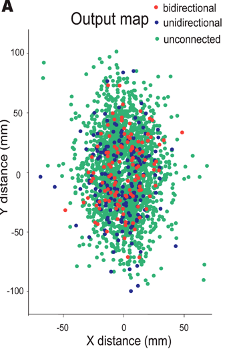

It does not show absolute neuron locations, but the _relative_ locations of sampled _pairs_. That is, for all pairs considered, one is at the origin of the plot, the other at the indicated locations. 

Our approach considers the distribution of sampled relative locations a two-dimensional Gaussian distribution and selects neurons to fulfill that constraint. The covariance matrix of the Gaussian is provided as an input.

In [ ]:
# Select a subpopulation by emulating a sampling procedure.
smpl = S_fltr.patch_sample(10, # Maximum number of neurons sampled together. The algorithm will attempt to find that number of 
                           # neurons that fulfill the spatial constraint. The number can be lower if no neuron is found at a 
                           # selected location. This is similar to wetlab experiments where not always the max. number is achieved.
                           
                           [0.0, 0.0], # Offset from the center of the slice (in um) that sampling will be centered around
                           
                           [[50.0**2, 0], # Covariance matrix of the Gaussian determining sampled relative locations.
                            [0, 50.0**2]] # In this case, the expected offset along hor. and vert. axes is 50 um.
                            )

# Convert to networkx for plotting
nx = smpl.to_networkx()

# Coordinates in the plance of the slice are provided (useful when a non-axis-alinged slicing angle has been used).
pos = dict([(k, [_node["slice_x"], _node["slice_y"]]) for k, _node in nx.nodes.items()])

networkx.draw(nx, pos=pos)
ax = plt.gca()
ylim = ax.get_ylim(); xlim = ax.get_xlim()
y_pos = 0.97 * ylim[0] + 0.03 * ylim[1]
x_pos = 0.1 * xlim[0] + 0.9 * xlim[1]
ax.plot(x_pos + numpy.array([-50.0, 0.0]),
        y_pos + numpy.zeros(2), lw=5, color="grey")
ax.text(x_pos - 25.0, y_pos - 5.0, "50 um",
        horizontalalignment="center")

We can calculate the horizontal and vertical offsets of the sampled neurons and create a plot as above

In [ ]:
pos = smpl.vertices[["slice_x", "slice_y"]]
deltas = pos.values.reshape((-1, 1, 2)) - pos.values.reshape((1, -1, 2))
deltas = deltas.reshape((-1, 2))
deltas = pandas.DataFrame(deltas, columns=["dx", "dy"])
deltas["connected"] = smpl.array.astype(bool).flatten()

deltas = deltas.loc[(deltas["dx"] != 0) | (deltas["dy"] != 0)]
plt.scatter(deltas.loc[deltas["connected"], "dx"], deltas.loc[deltas["connected"], "dy"], color="red")
plt.scatter(deltas.loc[~deltas["connected"], "dx"], deltas.loc[~deltas["connected"], "dy"], color="blue")
plt.axis("equal")
plt.gca().set_xlabel("dx"); plt.gca().set_ylabel("dy")

## Repeated samplings

The above was an approximation of a single sampling experiment.

We wrap the logic into a loop that performs repeated sampling experiments on a slice and collects the statistics.

In [ ]:
def run_patch_sample_experiment(S, lst_mtypes_to_use, sd_x, sd_y, n_per_sample, n_samples,
                                rnd_offset_amplitude=50.0):
    """
    Args:
      lst_mtypes_to_use: List of neuron types to possibly sample from. Others will be ignored
      sd_x: Standard deviation of the sampling Gaussian along the horizontal axis (in um).
      sd_y: Standard deviation of the sampling Gaussian along the vertical axis (in um).
      n_per_sample: Maximum number of neurons to simultaneously sample.
      n_samples: Number of repetitions of the sampling experiment.
      rnd_offset_amplitude (default: 50 um): Repetitions of the sampling experiment are performed at
        randomly generated offsets from the center of the slice. This is the maximum amplitude of offsets.
    """
    S = S.index("mtype").isin(lst_mtypes_to_use)
    v_x = sd_x ** 2; v_y = sd_y ** 2
    all_deltas = []
    for _ in range(n_samples):
        rnd_offset = numpy.random.rand(2) * rnd_offset_amplitude - (rnd_offset_amplitude / 2)
        smpl = S.patch_sample(n_per_sample, rnd_offset, [[v_x, 0], [0, v_y]])

        pos = smpl.vertices[["slice_x", "slice_y"]]
        deltas = pos.values.reshape((-1, 1, 2)) - pos.values.reshape((1, -1, 2))
        deltas = deltas.reshape((-1, 2))
        deltas = pandas.DataFrame(deltas, columns=["dx", "dy"])
        deltas["connected"] = smpl.array.astype(bool).flatten()

        deltas = deltas.loc[(deltas["dx"] != 0) | (deltas["dy"] != 0)]
        all_deltas.append(deltas)

    all_deltas = pandas.concat(all_deltas, axis=0).reset_index(drop=True)
    return all_deltas

all_deltas = run_patch_sample_experiment(S, lst_mtypes_to_use,
                                         55.0, 55.0,
                                         8, 25)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(all_deltas.loc[~all_deltas["connected"], "dx"],
            all_deltas.loc[~all_deltas["connected"], "dy"], color="blue", s=5, alpha=0.4)
plt.scatter(all_deltas.loc[all_deltas["connected"], "dx"],
            all_deltas.loc[all_deltas["connected"], "dy"], color="red", s=7)
plt.axis("equal")
plt.gca().set_xlabel("dx"); plt.gca().set_ylabel("dy")

print(f"{all_deltas["connected"].sum()} out of {len(all_deltas)} connected. Connection probability: {100 * all_deltas["connected"].mean()}%")

### Reliability of the procedure
How reliable are estimates obtained from this?

To estimate this, we repeatedly generate connection probability estimates as above, and assess their variability.
Below, the parameters used will lead to ~200 pairs of neurons being sampled for one connection probability estimate. For comparison, the Jiang et al. paper mentioned above reportedly sampled 150 pairs of L5PCs.

In [ ]:
res = []
for _ in range(100):
    all_deltas = run_patch_sample_experiment(S, lst_mtypes_to_use,
                                            30.0, 75.0,
                                            5, 10)
    res.append(all_deltas["connected"].mean())

print(f"Variability of estimates: {100 * numpy.std(res) / numpy.mean(res)}%")
plt.bar(range(100), res)

The plot of the Song et al., 2005 paper we showed above has one particularity: The offset along the vertical axis tends to be larger thatn the offset along the horizontal axis for the sampled pairs.

Here we compare sampling with a bias for a vertical offset to sampling with a bias for horizontal offset. Does this bias the generated connection probability estimates?

In [ ]:
all_deltas = run_patch_sample_experiment(S, lst_mtypes_to_use,
                                         30.0, 75.0,
                                         10, 100)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(all_deltas.loc[~all_deltas["connected"], "dx"],
            all_deltas.loc[~all_deltas["connected"], "dy"], color="blue", s=5, alpha=0.4)
plt.scatter(all_deltas.loc[all_deltas["connected"], "dx"],
            all_deltas.loc[all_deltas["connected"], "dy"], color="red", s=7)
plt.axis("equal")

print(f"Connection probability: {all_deltas["connected"].mean()}")

all_deltas = run_patch_sample_experiment(S, lst_mtypes_to_use,
                                         75.0, 30.0,
                                         10, 100)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(all_deltas.loc[~all_deltas["connected"], "dx"],
            all_deltas.loc[~all_deltas["connected"], "dy"], color="blue", s=5, alpha=0.4)
plt.scatter(all_deltas.loc[all_deltas["connected"], "dx"],
            all_deltas.loc[all_deltas["connected"], "dy"], color="red", s=7)
plt.axis("equal")

print(f"Connection probability: {all_deltas["connected"].mean()}")

### Interactive widget

Below, we place an interactive widget allowing you to quickly adjust parameters of a sampling experiment.

In [ ]:
from ipywidgets import widgets

def display_patch_sample_experiment(*args, **kwargs):
    all_deltas = run_patch_sample_experiment(S, *args, **kwargs)

    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(all_deltas.loc[~all_deltas["connected"], "dx"],
                all_deltas.loc[~all_deltas["connected"], "dy"], color="blue", s=5, alpha=0.4)
    plt.scatter(all_deltas.loc[all_deltas["connected"], "dx"],
                all_deltas.loc[all_deltas["connected"], "dy"], color="red", s=7)
    plt.axis("equal")

    print(f"Connection probability: {all_deltas["connected"].mean()}")

lst_possible_mtypes = S.vertices["mtype"].drop_duplicates().astype(str).sort_values()

wgt_mtypes = widgets.SelectMultiple(options=lst_possible_mtypes,
                                   index=[0, 1, 2],
                                   description="Neuron types")
wgt_sd_x = widgets.FloatSlider(min=25.0, max=200.0, value=70.0)
wgt_sd_y = widgets.FloatSlider(min=25.0, max=200.0, value=70.0)
wgt_n_per_smpl = widgets.IntSlider(min=4, max=30, step=1, value=10)
wgt_n_smpl = widgets.IntSlider(min=50, max=1000, value=100)


i = widgets.interactive(display_patch_sample_experiment, lst_mtypes_to_use=wgt_mtypes,
                        sd_x=wgt_sd_x, sd_y=wgt_sd_y, n_per_sample=wgt_n_per_smpl, n_samples=wgt_n_smpl)

display(i)

# At larger distances, connection probabilities become problematic

We make one last point: Connection probabilities are typically used to describe connectivity at very low distances, e.g., below 100 um. We argue that the majority of connections formed by a neuron (even local connections!) are beyond that distance. 

They are often neglected, because connection probabilities fall drastically with distance, leading people to consider the low probabilities as "essentially zero". However, while the probabilities are low, they still represent a large number of connections, simply because there are many more potential partners to connect to at larger distances.

As a demonstration, we plot the connection probability and the number of connected neurons in 50um bins.


In [ ]:
from scipy.spatial import KDTree
xyz = ["x", "y", "z"]

# Here: All excitatory neurons
M = conntility.ConnectivityMatrix.from_h5(fn)
M = M.index("synapse_class").eq("EXC")

# Generate 50 um bins
dbins = numpy.arange(0, 750, 50)

# Using a KDTree to calculate the number of pairs within the bins
# We could also generate the full matrix of pairwise distances, but that grows huge for many neurons in the sample
tree = KDTree(M.vertices[xyz])
# Number of pairs of neurons in each distance bin, connected or unconnected
npairs = numpy.diff(tree.count_neighbors(tree, dbins))

In [ ]:
# Now, for comparison we calculate the number of _connected_ neurons in each distance bin
deltas = []
for _col in xyz:
    # This function returns a DataFrame, with one row for each connections;
    # columns hold the x, y, or z-coordinate of the neurons participating in the connection. 
    df = M.edge_associated_vertex_properties(_col)
    # Subtracting coordinate of the pre-synaptic ("row") from the post-synaptic ("col") partner in the connection
    deltas.append(df["col"] - df["row"])

dists = numpy.linalg.norm(pandas.concat(deltas, axis=1), axis=1)
nconnections = numpy.histogram(dists, bins=dbins)[0]

fig = plt.figure(figsize=(7, 3))

ax = fig.add_subplot(1, 2, 1)
# Connection probability: Connections divided by pairs
ax.bar(dbins[:-1], nconnections / npairs, width=50.0)
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")

ax = fig.add_subplot(1, 2, 2)
ax.bar(dbins[:-1], nconnections, width=50.0)
ax.set_frame_on(False)
ax.set_xlabel("Distance (um)")
ax.set_ylabel("Connected pairs")

display(numpy.percentile(dists, 50))

We see that there is a substantial number of connections at distances beyond 200 um, although the connection probabilities are below 0.3%. 
It seems like missing them would be problematic. However, it is difficult to characterize this through sampling techniques such as the one we emulated above. Enormous accuracy would be required, as even a difference of 0.5% connection probability represents a very large number of connections at the larger distances. Sampling procedures provide do not provide this, unless a vast number of pairs is sampled.